# Example Place Cells Visualization

This notebook contains plots of example cells from the place cell analysis. 

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.spikes import compute_firing_rate
from spiketools.measures.conversions import convert_times_to_rates
from spiketools.spatial.occupancy import (compute_bin_counts_assgn, compute_bin_edges, 
                                          compute_bin_assignment, normalize_bin_counts)
from spiketools.spatial.information import compute_spatial_information
from spiketools.spatial.place import (compute_occupancy, compute_bin_counts_pos,
                                      compute_place_bins, compute_trial_place_bins)
from spiketools.spatial.utils import compute_nbins, compute_pos_ranges, convert_2dindices
from spiketools.spatial.target import compute_target_bins
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.utils.base import select_from_list
from spiketools.utils.data import compute_range
from spiketools.utils.extract import (get_range, get_value_by_time, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_times)
from spiketools.utils.epoch import (epoch_data_by_range, epoch_spikes_by_segment, 
                                    epoch_spikes_by_range, epoch_spikes_by_event)

from spiketools.plts.data import plot_bar, plot_hist
from spiketools.plts.spatial import plot_heatmap, plot_positions, create_heat_title
from spiketools.plts.trials import plot_rasters
from spiketools.plts.stats import plot_surrogates
# from spiketools.plts.style import drop_spines
# from spiketools.plts.utils import make_axes, make_grid, get_grid_subplot, save_figure

In [3]:
import sys
sys.path.append('../code')
from models import * 
from utils import *
from plts import *

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/clairehan/Documents/Data/JacobsLab/WVTH/nwb'

In [6]:
# Define session information
session = {
    'experiment' : 'THF',
    'subject' : 'wv001',
    'session' : 4
}

In [7]:
# Set which example unit to extract
uind = 52

In [8]:
# Define binning for chests (spatial target)
chest_bins = [5, 8]
bins = [7, 10]

n_bins = compute_nbins(chest_bins)

In [9]:
# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

occ_kwargs = {'minimum' : min_occ, 'normalize' : False, 'set_nan' : True}

In [10]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'
# shuffle_approach = 'BINCIRC'
n_surrogates = 25

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}

In [11]:
# Set which analysis method to run
METHOD = 'ANOVA'

## Load data

In [12]:
# Get the list of NWB files
nwbfiles = get_files(data_folder)

In [13]:
# Load example NWB file
nwbfile = load_nwbfile(session, data_folder)

### Get trial data

In [14]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 40


In [15]:
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]
ch_openings_all = np.array(chest_openings).reshape(-1,1)

### Get spike data

In [16]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 93
Number to keep:  51


In [17]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

### Get position data

In [18]:
# Get area ranges, adding a buffer to the z-range (for tower transport)
area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:],
              nwbfile.acquisition['boundaries']['z_range'].data[:]]
area_range = [[area_range[0][0], area_range[0][1]], [area_range[1][0], area_range[1][1]]]

In [19]:
# Get position & speed information
positions = nwbfile.acquisition['position']['player_position'].data[:].T
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
speed = nwbfile.processing['position_measures']['speed'].data[:]

In [20]:
# Get position data for navigation segments
ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

# Recombine position data across selected navigation trials
ptimes = np.hstack(ptimes_trials)
positions = np.hstack(positions_trials)
stimes = np.hstack(stimes_trials)
speed = np.hstack(speed_trials)

spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=0.1)

In [21]:
# Define the segment times of interest
seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)

## Subject position

In [22]:
# Check binning
x_bin_edges, y_bin_edges = compute_bin_edges(positions, bins, area_range)

# Compute place occupancy
occ = compute_occupancy(positions, ptimes, bins, area_range,
                        speed, speed_thresh, time_thresh, **occ_kwargs)

In [23]:
# Compute summary map of bin firing
bin_firing = compute_bin_counts_pos(spike_positions, bins, area_range)

# Normalize bin firing by occupancy
normed_bin_firing = normalize_bin_counts(bin_firing, occ)

## Chest position

In [24]:
# Define the area range for chest appearance 
area_range_chest = [[360, 410], [320, 400]]

# Get chest positions
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

# Compute edges for chest binning
x_edges, y_edges = compute_bin_edges(positions, chest_bins, area_range=area_range_chest)

# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_bin_assignment(chest_pos, x_edges, y_edges)

# Compute the 1d equivalent of the 2d indices
chbins = convert_2dindices(ch_xbin, ch_ybin, chest_bins)

chest_trial_number = np.array(list(range(len(chest_trials)))).reshape(n_trials,4)

In [25]:
# Compute chest occupancy
chest_occupancy = compute_bin_counts_assgn(chest_bins, ch_xbin, ch_ybin)

# Compute the segment firing rate per chest segment, per trial
target_frs = compute_segment_frs(spikes, seg_times)

# Compute the average firing across spatial target bins
target_bins = compute_target_bins(target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)
target_bins_reshaped = reshape_bins(target_bins, bins)

## One example place cell

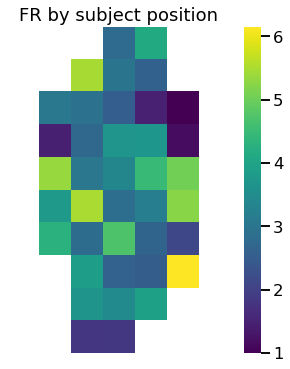

In [26]:
plot_heatmap(normed_bin_firing, title='FR by subject position', aspect='auto', cbar=True, figsize=(5,6))

## Place vs. target cell comparison

#### Statistical analysis (place)

In [27]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)

In [28]:
# Collect place firing, organized per trial
place_trial = compute_trial_place_bins(spikes, positions, ptimes, bins, nav_starts, nav_stops, 
                                       area_range, speed, speed_thresh, time_thresh,
                                       flatten=True, **occ_kwargs)

In [29]:
# Create the dataframe
df = create_df_place(place_trial, dropna=True)

In [30]:
# Fit the ANOVA, and get the f-value
f_val = fit_anova_place(df)

In [31]:
# Compute measures on surrogates
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    place_trial = compute_trial_place_bins(shuffle, positions, ptimes, bins, nav_starts, nav_stops,
                                           area_range, speed, speed_thresh, time_thresh,
                                           flatten=True, **occ_kwargs)
    surrogates[ind] = fit_anova_place(create_df_place(place_trial))

In [32]:
# Compute statistics on the surrogates
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True)

p-value: 0.00
z-score: 3.51


#### Statistical analysis (target)

In [33]:
# Create dataframe, with 1d (flattened) spatial bin labels
df_target = create_df_target({'trial' : chest_trials,
                       'target_bin' : chbins,
                       'fr' : target_frs.flatten()})

In [34]:
# Fit the ANOVA, and get the f-value
f_val_target = fit_anova_target(df_target)

In [35]:
# Compute measures on surrogates
surrogates_target = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    df_target = create_df_target({'trial' : chest_trials, 'target_bin' : chbins,
                           'fr' :compute_segment_frs(shuffle, seg_times).flatten()})
    surrogates_target[ind] = fit_anova_target(df_target)

In [36]:
# Compute statistics on the surrogates
p_val_target, z_score_target = compute_surrogate_stats(f_val_target, surrogates_target, verbose=True)

p-value: 0.00
z-score: 2.40


#### Plot with surrogates distributions

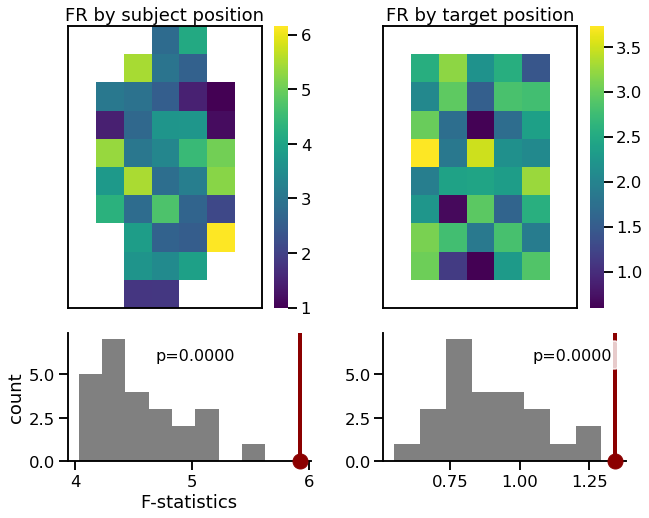

In [37]:
plot_place_target_comparison(normed_bin_firing, target_bins_reshaped, surrogates, surrogates_target, 8, 
                            f_val, f_val_target, p_val, p_val_target)

## All significant cells

In [57]:
# Load & merge the results sheets of THF & THO
df_THF = pd.read_excel("/Users/clairehan/Desktop/research/WVTH/THF_all_results.xlsx")
df_THO = pd.read_excel("/Users/clairehan/Desktop/research/WVTH/THO_all_results.xlsx")
df = df_THF.append(df_THO)

In [58]:
# Create a dataframe for significant spatial target cells
df_place = df[df.is_place_cell]
df_place.head()

,Unnamed: 0,session,uid,wvID,keep,cluster,channel,location,n_spikes,firing_rate,...,sp_p_val,sp_z_score,area,fr_keep_th,is_chest_cell,is_full_cell,is_empty_cell,is_place_cell,is_target_cell,is_sp_cell
30,30,THF_wv001_session_0,39,40,1,1605,A23,LPH,936,0.751214,...,0.160,0.909069,post hipp,False,False,False,False,True,False,False
53,53,THF_wv001_session_0,73,74,1,3960,A38,RAH,5514,4.464890,...,0.946,-1.079516,ant hipp,False,False,False,True,True,False,False
116,116,THF_wv001_session_2,60,161,1,3360,A38,RAH,691,0.413765,...,0.684,-0.625811,ant hipp,True,False,False,False,True,False,False
146,146,THF_wv001_session_3,112,294,1,2215,A7,LA,705,0.355239,...,0.968,-1.027694,amygdala,True,False,False,False,True,False,False
147,147,THF_wv001_session_3,113,295,1,2247,A7,LA,1394,0.700791,...,0.076,1.377871,amygdala,False,False,False,False,True,True,False


In [ ]:
for nwbfile in nwbfiles:
    nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
    name = nwbfile.session_id
    
    # Get indices of significant target cell from each session
    inds = np.where(df_place.session == name)[0]
    inds_uid = df_place.uid.iloc[inds].values
    
    # Get trial information 
    n_trials = len(nwbfile.trials)
    nav_starts = nwbfile.trials.navigation_start[:]
    nav_stops = nwbfile.trials.navigation_stop[:]
    chest_openings = nwbfile.trials['chest_opening_time'][:]
    ch_openings_all = np.array(chest_openings).reshape(-1,1)

    # Get area ranges, adding a buffer to the z-range (for tower transport)
    area_range = [nwbfile.acquisition['boundaries']['x_range'].data[:],
                  nwbfile.acquisition['boundaries']['z_range'].data[:] + np.array([-15, 15])]
    area_range = [[area_range[0][0], area_range[0][1]], [area_range[1][0], area_range[1][1]]]
    area_range_chest = [[360, 410], [320, 400]]
    
    # Get position & speed information
    positions = nwbfile.acquisition['position']['player_position'].data[:].T
    ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
    stimes = nwbfile.processing['position_measures']['speed'].timestamps[:]
    speed = nwbfile.processing['position_measures']['speed'].data[:]

    # Get position data for navigation segments
    ptimes_trials, positions_trials = epoch_data_by_range(ptimes, positions, nav_starts, nav_stops)
    stimes_trials, speed_trials = epoch_data_by_range(stimes, speed, nav_starts, nav_stops)

    # Recombine position data across selected navigation trials
    ptimes = np.hstack(ptimes_trials)
    positions = np.hstack(positions_trials)
    stimes = np.hstack(stimes_trials)
    speed = np.hstack(speed_trials)

    # Get chest positions
    chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
    chest_trials = nwbfile.trials.chest_trials[:]
    chest_trial_number = np.array(list(range(len(chest_trials)))).reshape(n_trials,4)
    
    # Compute edges for chest binning
    x_edges, y_edges = compute_bin_edges(positions, chest_bins, area_range=area_range_chest)
    
    # Check binning
    x_bin_edges, y_bin_edges = compute_bin_edges(positions, bins, area_range)

    # Assign each chest to a bin
    chest_pos = np.array([chest_xs, chest_ys])
    ch_xbin, ch_ybin = compute_bin_assignment(chest_pos, x_edges, y_edges)
    
    # Compute the 1d equivalent of the 2d indices
    chbins = convert_2dindices(ch_xbin, ch_ybin, chest_bins)

    # Compute chest & place occupancy
    chest_occupancy = compute_bin_counts_assgn(chest_bins, ch_xbin, ch_ybin)
    occ = compute_occupancy(positions, ptimes, bins, area_range,
                            speed, speed_thresh, time_thresh, **occ_kwargs)
    
    # Define the segment times of interest
    seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)
    
    for ind in inds_uid: 
        name_ind = nwbfile.session_id + '_U' + str(ind).zfill(2)
        
        # Get spike data for each significant unit
        spikes = nwbfile.units.get_unit_spike_times(ind)
        spike_positions = get_values_by_times(ptimes, positions, spikes, threshold=0.1)
        
        # Compute firing rate per spatial target bin
        target_frs = compute_segment_frs(spikes, seg_times)
        target_bins = compute_target_bins(target_frs, chest_bins, ch_xbin, ch_ybin, chest_occupancy)
        target_bins_reshaped = reshape_bins(target_bins, bins)
        
        # Compute summary map of bin firing
        bin_firing = compute_bin_counts_pos(spike_positions, bins, area_range)

        # Normalize bin firing by occupancy
        normed_bin_firing = normalize_bin_counts(bin_firing, occ)
        
        # Create shuffled time series for comparison
        times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates)
        
        # Collect place firing, organized per trial
        place_trial = compute_trial_place_bins(spikes, positions, ptimes, bins, nav_starts, nav_stops, 
                                               area_range, speed, speed_thresh, time_thresh,
                                               flatten=True, **occ_kwargs)
        # Create the dataframes
        df = create_df_place(place_trial, dropna=True)
        df_target = create_df_target({'trial' : chest_trials, 'target_bin' : chbins,
                                      'fr' : target_frs.flatten()})
        
        # Fit the ANOVA, and get the f-value
        f_val = fit_anova_place(df)
        f_val_target = fit_anova_target(df_target)
        
        # Compute measures on surrogates
        surrogates = np.zeros(n_surrogates)
        surrogates_target = np.zeros(n_surrogates)
        for ind, shuffle in enumerate(times_shuffle):
            place_trial = compute_trial_place_bins(shuffle, positions, ptimes, bins, nav_starts, nav_stops,
                                                   area_range, speed, speed_thresh, time_thresh,
                                                   flatten=True, **occ_kwargs)
            surrogates[ind] = fit_anova_place(create_df_place(place_trial))
            
            df_target = create_df_target({'trial' : chest_trials, 'target_bin' : chbins,
                                          'fr' :compute_segment_frs(shuffle, seg_times).flatten()})
            surrogates_target[ind] = fit_anova_target(df_target)
        
        # Compute statistics on the surrogates
        p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=False)
        p_val_target, z_score_target = compute_surrogate_stats(f_val_target, surrogates_target, verbose=False)
        
        # Plot place & target side by side with surrogates distribution
        plot_place_target_comparison(normed_bin_firing, target_bins_reshaped, surrogates, surrogates_target, 10, 
                            f_val, f_val_target, p_val, p_val_target)